# Measurement Memory
In the optimization of the flight path, we need to compute measurements at many positions, which is expensive for the convolution type measurements. However, during the optimization's steps, especially towards the end when the algorithm converges, those measurement positions don't actually change that much. It therefore makes sense to save them instead than computing them from scratch every time.

## Imports

In [1]:
import sys
sys.path.insert(0, "../source/")
sys.path.insert(0, "../models/AdvectionDiffusion/settings/AdvectionDiffusion_FEniCS")
sys.path.insert(0, "../models/AdvectionDiffusion/Navigators")
sys.path.insert(0, "../models/AdvectionDiffusion/Detectors")

import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la

from InverseProblem import InverseProblem
from OEDUtility import OEDUtility
from Drone import Drone as Drone

from DetectorPointwise import DetectorPointwise
from DetectorUniform import DetectorUniform
from DetectorGaussian import DetectorGaussian
from DetectorTruncGaussian import DetectorTruncGaussian
from NavigationCircle import NavigationCircle as Navigation

import time
tStart_notebook = time.time()

## User settings

In [2]:
centers = [[0.4, 0.6], [0.6, 0.4]]
var_prior = 1 # set to a high value (1e+6) to test convergence in noise-free situations

n_test_2d = 100  # resolution for 2D plots (50: ~1 min runtime for dt = 0.01)

n_steps = 100

sigma = 0.05  # std deviation for gaussian-type measurements. Get pointwise data for sigma -> 0
radius = 0.05  # truncation radius for truncation-style measurements

meshDim = 50  # discretization parameter (1D) for FOM
meshDim_drone = 10  # discretization parameter (1D) for subdomain in truncation-type measurements
polyDim = 3

bool_transient = False  # stationary or transient model?

# what kind of measurements
which_detector = "truncGaussian" #"pointwise" #"truncGaussian" #"uniform" #"pointwise"

## Setup

In [3]:
# import classes according to settings

# transient or stationary model?
if bool_transient:
    from FOM import FOM as FOM
else:
    from FOM_stationary import FOM_stationary as FOM
    
# what type of measurements?
if which_detector == "pointwise":
    from DetectorPointwise import DetectorPointwise as Detector
elif which_detector == "uniform":
    from DetectorUniform import DetectorUniform as Detector
elif which_detector == "truncGaussian":
    from DetectorTruncGaussian import DetectorTruncGaussian as Detector
elif which_detector == "Gaussian":
    raise NotImplementedError("DetectorGaussian not yet supported for transient problems (need to figure out boundary conditions)")
else:
    raise RuntimeError("invalid detector class")

initializations

In [4]:
# initialize full-order model
tStart = time.time()
fom = FOM(meshDim = meshDim, centers=centers, polyDim=polyDim)
print("Runtime of this block: {} s".format(time.time()-tStart))
n_para = fom.n_para

# set a prior
prior_mean = np.zeros((n_para,))
prior_covar = var_prior*np.eye(n_para)
fom.set_prior(prior_mean=prior_mean, prior_covar=prior_covar)

# NavigationCircle was imported as Navigation
navigation = Navigation(grid_t = np.linspace(0, 4, n_steps))

# point-wise measurements
detector = Detector(fom)

# initialize drone
drone = Drone(detector=detector, navigation=navigation)

Runtime of this block: 1.8516368865966797 s


## Remembering measurements

We start off from an arbitrary state for which we want to take measurements. In the optimization, there will be one state for each parameter basis function. Here we only look at one to demonstrate.

In [5]:
para = np.ones((n_para,))

tStart = time.time()
state = fom.solve(parameter=para)
print("FOM solve time: {} s.".format(time.time()-tStart))

FOM solve time: 0.32463574409484863 s.


We choose flight path that is approximate a quarter circle, just for demonstration:

In [6]:
# user setting: characterize the flight path
alpha = np.array([0.25, 0.1]) # radius, speed

# compute flight for alpha
flight = drone.plan_flight(alpha=alpha)

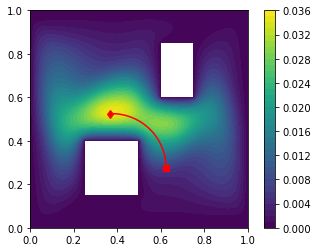

In [7]:
flightpath, grid_t = flight.flightpath, flight.grid_t

fom.plot(state, time=grid_t[-1])
plt.plot(flightpath[:, 0], flightpath[:, 1], color="r")
plt.plot([flightpath[0, 0]], [flightpath[0, 1]], color="r", marker="s")
plt.plot([flightpath[-1, 0]], [flightpath[-1, 1]], color="r", marker="d")

In our baseline code, a measurement along this path takes about half a second. If the same code is run again, it takes about the same time again. Obviously that's not efficient when the discretization is fine and we need to take many measurements several times in the course of the optimization.

In [8]:
# measure data
tStart = time.time()
data = drone.measure(flight=flight, state=state)
print("measurement time (run 1): ", time.time()-tStart, "s.")

tStart = time.time()
data = drone.measure(flight=flight, state=state)
print("measurement time (run 2): ", time.time()-tStart, "s.")

measurement time (run 1):  0.42157483100891113 s.
measurement time (run 2):  0.4457089900970459 s.
